In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling as pp
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from textblob import TextBlob
import spacy
from spacy import displacy

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/brianlouie/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/brianlouie/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel/k

In [2]:
wine = pd.read_csv('data/winemag-data-130k-v2.csv.zip', index_col=0)

#removed index column from the csv file

In [3]:
wine.shape

(129971, 13)

In [107]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,region,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Etna,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Douro,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Willamette Valley,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Lake Michigan Shore,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Willamette Valley,2012.0


In [4]:
wine[wine.duplicated(['description','title'])].shape[0]
#9983 descriptions are duplicates

9983

In [5]:
wine = wine.drop_duplicates(['description','title'])
wine.shape

(119988, 13)

In [6]:
wine.isnull().sum().sort_values(ascending=False)

region_2                 73219
designation              34545
taster_twitter_handle    29446
taster_name              24917
region_1                 19560
price                     8395
province                    59
country                     59
variety                      1
winery                       0
title                        0
points                       0
description                  0
dtype: int64

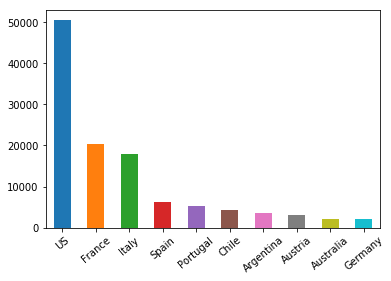

In [7]:
wine['country'].value_counts()[:10].plot(kind='bar',rot=40)
plt.show()

#largest 10 wine producers in this dataset

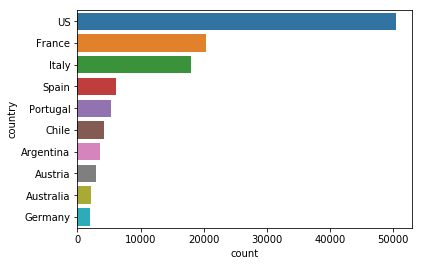

In [8]:
df = wine[wine.country.isin(wine.country.value_counts().head(10).index)]
ax = sns.countplot(y='country', data = df, order= wine['country'].value_counts().head(10).index)


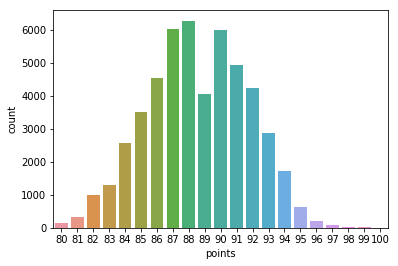

In [56]:
sns.countplot(data = wine[wine['country'] =='US'], x='points')
plt.show()

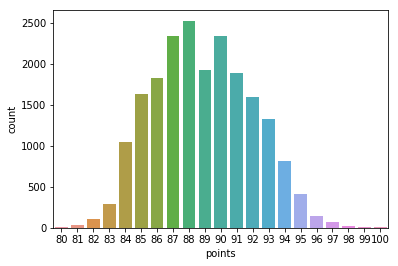

In [55]:
sns.countplot(data = wine[wine['country'] =='France'], x='points') 
plt.show()

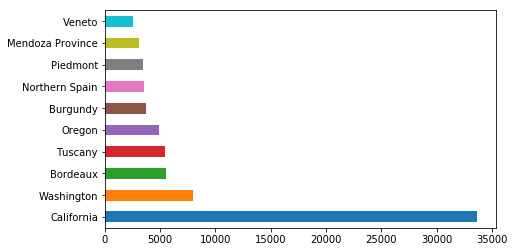

In [9]:
wine['province'].value_counts()[:10].plot(kind='barh',figsize=(7,4))
plt.show()

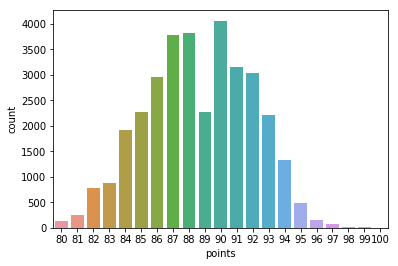

In [57]:
sns.countplot(data = wine[wine['province'] =='California'], x='points')
plt.show()

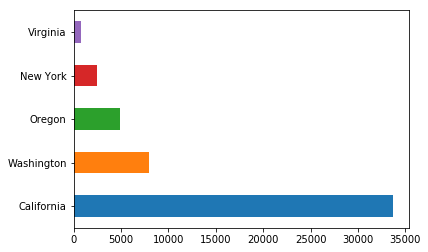

In [10]:
wine[wine['country']=='US']['province'].value_counts()[:5].plot(kind='barh')
plt.show()

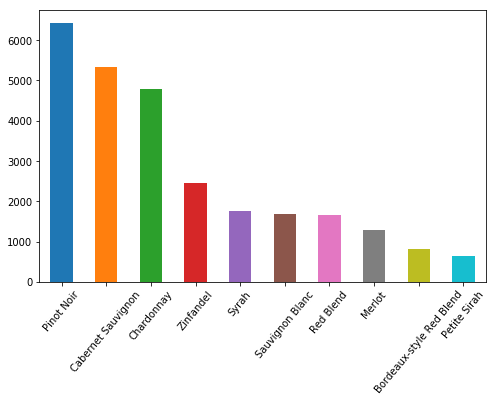

In [11]:
wine[wine['province']=='California']['variety'].value_counts()[:10].plot(kind='bar', figsize = (8,5), rot=50)
plt.show()

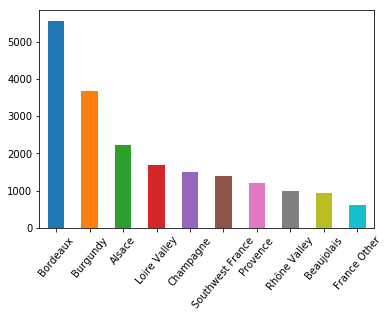

In [12]:
wine[wine['country']=='France']['province'].value_counts()[:10].plot(kind='bar',rot=50)
plt.show()

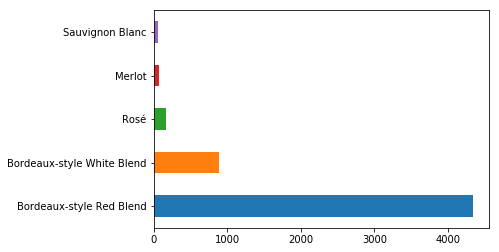

In [69]:
wine[wine['province']=='Bordeaux']['variety'].value_counts()[:5].plot(kind='barh')
plt.show()

In [13]:
wine.variety.value_counts()[:10]

Pinot Noir                  12278
Chardonnay                  10868
Cabernet Sauvignon           8840
Red Blend                    8243
Bordeaux-style Red Blend     6471
Riesling                     4773
Sauvignon Blanc              4575
Syrah                        3828
Rosé                         3220
Merlot                       2896
Name: variety, dtype: int64

In [14]:
wine_variety = wine.variety.unique()
len(wine_variety)

#708 unique wine types 

708

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


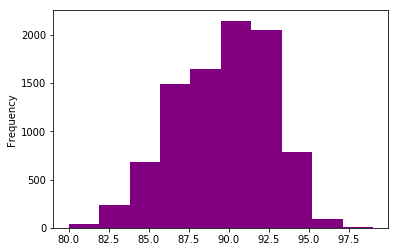

In [15]:
US_pinotnoir = wine[wine['country'] == 'US'][wine['variety']== 'Pinot Noir']
US_pinotnoir['points'].plot(kind='hist', color = 'purple')

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


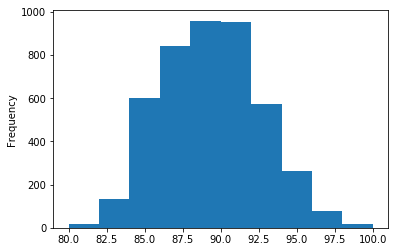

In [16]:
Fra_pinotnoir = wine[wine['country'] == 'France'][wine['variety']== 'Bordeaux-style Red Blend']
Fra_pinotnoir['points'].plot(kind='hist')

In [17]:
ita_pinotnoir = wine[wine['country'] == 'Italy'][wine['variety']== 'Pinot Noir']
esp_pinotnoir = wine[wine['country'] == 'Spain'][wine['variety']== 'Pinot Noir']

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5,1,'France Pinot Noir Wine Mag rankings')

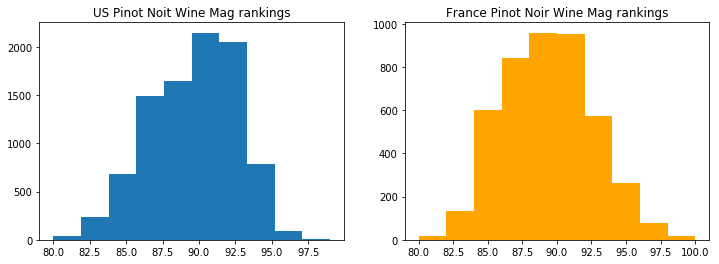

In [18]:
plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
plt.hist(US_pinotnoir['points'])
plt.title('US Pinot Noit Wine Mag rankings')

plt.subplot(1,2,2)
plt.hist(Fra_pinotnoir['points'], color = 'orange')
plt.title('France Pinot Noir Wine Mag rankings')


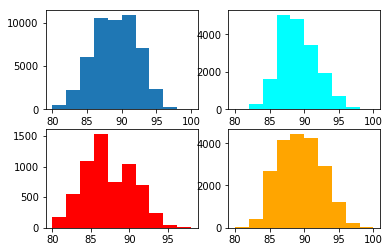

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2)


plt.subplot(2,2,1)
us_rating = wine[wine['country']== 'US']['points']
plt.hist(us_rating)

plt.subplot(2,2,2)
ita_rating = wine[wine['country']== 'Italy']['points']
plt.hist(ita_rating, color='aqua')

plt.subplot(2,2,3)
esp_rating = wine[wine['country']== 'Spain']['points']
plt.hist(esp_rating, color='red')

plt.subplot(2,2,4)
fra_rating = wine[wine['country']== 'France']['points']
plt.hist(fra_rating, color='orange')

plt.show()

In [20]:
wine.points.describe()

count    119988.000000
mean         88.442236
std           3.092915
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [21]:
wine[wine['points'] > 88.5].shape

(56737, 13)

In [22]:
wine[wine['points'] < 86.5].shape
#bad wines - in bottom 25-percentile of ratings

(32681, 13)

In [23]:
tasters = wine['taster_name'].value_counts()
len(tasters)

19

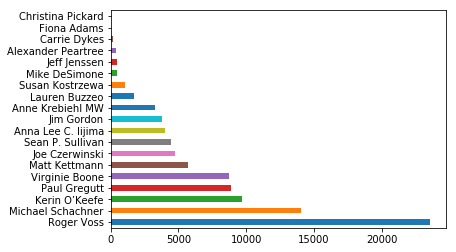

In [24]:
tasters.plot(kind='barh')
plt.show()

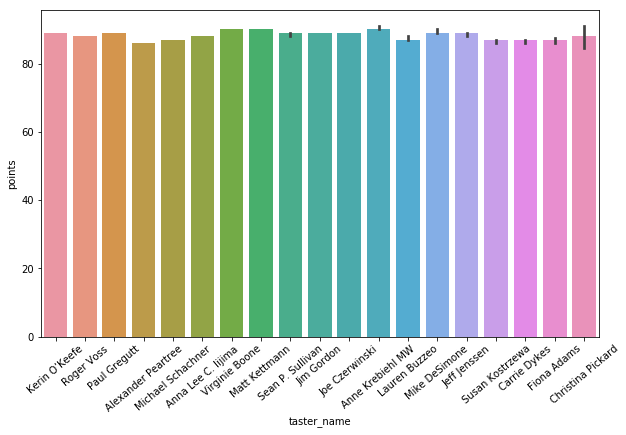

In [25]:
plt.figure(figsize=(10,6))
from numpy import median
ax = sns.barplot(x = 'taster_name', y='points', data=wine , estimator=median)
 
for item in ax.get_xticklabels():
    item.set_rotation(40)

In [83]:
wine.groupby(['taster_name'])['points'].mean()

taster_name
Alexander Peartree    85.780679
Anna Lee C. Iijima    88.416480
Anne Krebiehl MW      90.625228
Carrie Dykes          86.356589
Christina Pickard     87.833333
Fiona Adams           86.750000
Jeff Jenssen          88.330275
Jim Gordon            88.603558
Joe Czerwinski        88.524339
Kerin O’Keefe         88.897803
Lauren Buzzeo         87.692941
Matt Kettmann         90.061431
Michael Schachner     86.857112
Mike DeSimone         89.125813
Paul Gregutt          89.094159
Roger Voss            88.733107
Sean P. Sullivan      88.754988
Susan Kostrzewa       86.575758
Virginie Boone        89.220946
Name: points, dtype: float64

In [26]:
wine['variety'].fillna(value = 'Unknown', inplace=True)

In [27]:
wine['variety'].isnull().value_counts()

False    119988
Name: variety, dtype: int64

In [28]:
wine['country'].isnull().value_counts()

False    119929
True         59
Name: country, dtype: int64

In [29]:
wine['country'].fillna(value = 'Unknown', inplace=True)
wine['country'].isnull().value_counts()

False    119988
Name: country, dtype: int64

In [30]:
country_variety = wine.groupby(['country','variety'])['variety'].size()
country_variety



country    variety                          
Argentina  Barbera                                 1
           Bonarda                                98
           Bordeaux-style Red Blend               82
           Bordeaux-style White Blend              1
           Cabernet Blend                          8
           Cabernet Franc                         56
           Cabernet Franc-Cabernet Sauvignon       3
           Cabernet Franc-Malbec                   3
           Cabernet Sauvignon                    509
           Cabernet Sauvignon-Cabernet Franc       1
           Cabernet Sauvignon-Malbec              11
           Cabernet Sauvignon-Merlot               5
           Cabernet Sauvignon-Shiraz               3
           Cabernet Sauvignon-Syrah                2
           Cabernet-Malbec                         1
           Cabernet-Syrah                          1
           Champagne Blend                         8
           Chardonnay                            279
 

In [31]:
region_df = wine[(wine['region_1']) != (wine['region_2'])]
region_df.shape[0]

115123

In [32]:
region_df.tail()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss
129970,France,"Big, rich and off-dry, this is powered by inte...",Lieu-dit Harth Cuvée Caroline,90,21.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...,Gewürztraminer,Domaine Schoffit


In [33]:
list(wine.title[30:45])

#looking to pull year of vintage out of the title
#also inside parenthesis is the Region, can use this to fill in NaN values

['Domaine de la Madone 2012 Nouveau  (Beaujolais-Villages)',
 "Duca di Salaparuta 2010 Calanìca Nero d'Avola-Merlot Red (Sicilia)",
 'Duca di Salaparuta 2011 Calanìca Grillo-Viognier White (Sicilia)',
 'Envolve 2010 Puma Springs Vineyard Red (Dry Creek Valley)',
 'Envolve 2011 Sauvignon Blanc (Sonoma Valley)',
 'Erath 2010 Hyland Pinot Noir (McMinnville)',
 'Estampa 2011 Estate Viognier-Chardonnay (Colchagua Valley)',
 'Feudi del Pisciotto 2010 Missoni Cabernet Sauvignon (Sicilia)',
 'Feudi di San Marzano 2011 I Tratturi Primitivo (Puglia)',
 "Feudo di Santa Tresa 2011 Purato Made With Organic Grapes Nero d'Avola (Sicilia)",
 'Feudo Montoni 2011 Catarratto (Sicilia)',
 'Hawkins Cellars 2009 Pinot Noir (Willamette Valley)',
 'Henry Fessy 2012 Nouveau  (Beaujolais)',
 'Robert Hall 2011 Sauvignon Blanc (Paso Robles)',
 'Sundance 2011 Merlot (Maule Valley)']

In [34]:
def name_split(string):
   brian = string.split(sep='(')
   brian1 = brian[-1].split(sep=')')
   return brian1[0]
wine['region'] = wine['title'].map(name_split)
wine.head()

#replaced region_1 and region_2 columns with single region column with 'Region name' pulled fmor title feature

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,region
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Etna
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Douro
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Willamette Valley
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Lake Michigan Shore
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Willamette Valley


In [35]:
wine['title'].str.split()[:4]

0               [Nicosia, 2013, Vulkà, Bianco, (Etna)]
1    [Quinta, dos, Avidagos, 2011, Avidagos, Red, (...
2    [Rainstorm, 2013, Pinot, Gris, (Willamette, Va...
3    [St., Julian, 2013, Reserve, Late, Harvest, Ri...
Name: title, dtype: object

In [36]:
[int(s) for s in wine['title'].str.split()[4] if s.isdigit()]

[2012]

In [37]:
wine['title'] = wine['title'].astype(str)

In [38]:
wine['year'] = wine.title.str.extract('(\d{4})')

In [39]:
wine['year'].head()

0    2013
1    2011
2    2013
3    2013
4    2012
Name: year, dtype: object

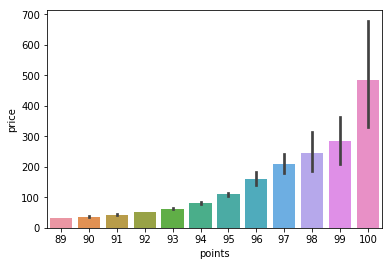

In [108]:
ax = sns.barplot(x="points", y="price", data=wine[wine['points']>88.5])

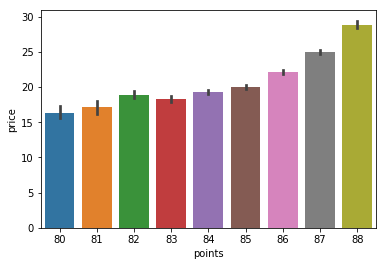

In [109]:
ax = sns.barplot(x="points", y="price", data=wine[wine['points']<88.5])

In [58]:
from datetime import datetime
wine['year'] = pd.to_datetime(wine.year, errors = 'coerce')
wine.info()
wine['year']= wine.year.dt.year

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 15 columns):
country                  119988 non-null object
description              119988 non-null object
designation              85443 non-null object
points                   119988 non-null int64
price                    111593 non-null float64
province                 119929 non-null object
region_1                 100428 non-null object
region_2                 46769 non-null object
taster_name              95071 non-null object
taster_twitter_handle    90542 non-null object
title                    119988 non-null object
variety                  119988 non-null object
winery                   119988 non-null object
region                   119988 non-null object
year                     115690 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(12)
memory usage: 19.6+ MB


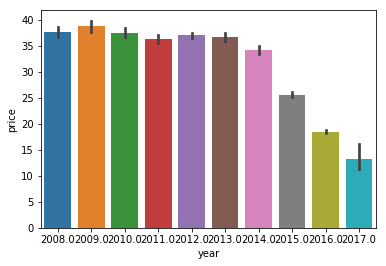

In [59]:
ax = sns.barplot(x="year", y="price", data=wine[wine['year']>2007])

### Working with NLP and textblob on wine description 

In [60]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import sent_tokenize
import re

In [61]:
wine.description[3]

'Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.'

In [62]:
review = wine.description[3]
analysis = TextBlob(review)

In [63]:
analysis.noun_phrases

WordList(['pineapple', 'lemon pith', 'orange blossom', 'semidry finish'])

In [64]:
analysis.sentiment

Sentiment(polarity=0.16666666666666669, subjectivity=0.3333333333333333)

In [69]:
def polarity_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

In [70]:
def subjectivity_calc(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

In [71]:
wine['polarity'] = wine['description'].apply(polarity_calc)
wine['subjectivity'] = wine['description'].apply(subjectivity_calc)

In [72]:
wine[['polarity', 'subjectivity']].head()

,polarity,subjectivity
0,0.133333,0.733333
1,0.220000,0.460000
2,0.025000,0.358333
3,0.166667,0.333333
4,0.306667,0.448718


In [73]:
wine[['polarity', 'subjectivity']].describe()

,polarity,subjectivity
count,129971.000000,129971.000000
mean,0.156991,0.496492
std,0.170302,0.151836
min,-0.800000,0.000000
25%,0.042857,0.401886
50%,0.154167,0.500000
75%,0.266667,0.593788
max,1.000000,1.000000


In [66]:
rating = wine.description[8]
rating

"Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine. It's fruity and fresh, with an elegant, sprightly footprint."

In [67]:
if re.search(r'fruit.',wine.description[8]):
        print("fruity wine")
    

fruity wine


In [68]:
txt = 'fruit\w+'

In [69]:
re.findall(txt, rating)

['fruity']

In [70]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
transformer

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [102]:
vect = TfidfVectorizer(min_df = 4, stop_words='english', lowercase = True, max_features=600)

In [104]:
wine_sample = wine.description[:100]
X= vect.fit_transform(wine_sample)

In [105]:
wineX = X.toarray()

In [106]:
wine_vocab = vect.get_feature_names()
wine_words = pd.DataFrame(wineX, columns = wine_vocab)
wine_words.head()

,acidity,alongside,apple,apricot,aromas,balanced,barrel,berry,bit,black,...,tobacco,tones,touch,tropical,vanilla,varieties,vineyard,white,wine,wood
0,0.202144,0.298266,0.298266,0.0,0.158380,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.337915,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.237329,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.275526,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.179113,0.0
2,0.255854,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.193094,0.0
3,0.000000,0.000000,0.000000,0.0,0.180027,0.0,0.0,0.000000,0.366618,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.186774,0.0


In [124]:
reg_test = pd.concat([wine['points'],wine_words])
reg_test.head()

,0,acidity,alongside,apple,apricot,aromas,balanced,barrel,berry,bit,...,tobacco,tones,touch,tropical,vanilla,varieties,vineyard,white,wine,wood
0,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
df.rename(columns={"0": "points" }, inplace = True)

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
